In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
from flopco_keras import FlopCoKeras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
global wvec
wvec = np.linspace(0, 1, 96) #create a omega vec

def SHO_fit_func(*parms):
    #SHO Fit function

    Amp, w_0, Q, phi = parms
    local_wvec=np.copy(wvec)
    w0 = 340E5
    wmax = 360E5
    Amp = 1E-3 * Amp
    w_0 = w0 + w_0*1E8*wmax #Scale it up
    phi = -1*np.pi+2*np.pi*phi #Scale it up
    Q = Q*100 #Scale it up
    local_wvec = local_wvec*1E8*wmax + w0
    func = Amp * np.exp(1.j * phi) * w_0 ** 2 / (local_wvec ** 2 - 1j * local_wvec * w_0 / Q - w_0 ** 2)
    noise=0.0025*np.random.uniform(0,1)
    func=func+noise*1j*np.random.normal(0,1,len(local_wvec))+noise*np.random.normal(0,1,len(local_wvec))

    return func

def SHO_fit_func_no_noise(*parms):
    #SHO Fit function
    Amp, w_0, Q, phi = parms
    local_wvec=np.copy(wvec)
    w0 = 340E5
    wmax = 360E5
    Amp = 1E-3 * Amp
    w_0 = w0 + w_0*1E8*wmax #Scale it up
    phi = -1*np.pi+2*np.pi*phi #Scale it up
    Q = Q*100 #Scale it up
    local_wvec = local_wvec*1E8*wmax + w0
    func = Amp * np.exp(1.j * phi) * w_0 ** 2 / (local_wvec ** 2 - 1j * local_wvec * w_0 / Q - w_0 ** 2)
    noise=0.000*np.random.uniform(0,1)
    func=func+noise*1j*np.random.normal(0,1,len(local_wvec))+noise*np.random.normal(0,1,len(local_wvec))

    return func

def return_split_data(input_mat):
    #Given a 2d matrix with complex values return a real and imag matrix
    a,b = input_mat.shape
    final_mat = np.zeros(shape=(a,b,2))
    final_mat[:,:,0] = np.real(input_mat)
    final_mat[:,:,1] = np.imag(input_mat)


    return final_mat

def generate_dataset(num_curves, wvec): 
    
    func_results= np.zeros(shape =(int(num_curves), len(wvec)), dtype = np.complex64)
    func_parms = np.zeros(shape = (int(num_curves), 4))
    A_range = [0, 1]
    Q_range = [0,1]
    w_range = [min(wvec) + 0.1*len(wvec)*(wvec[1] - wvec[0]), max(wvec) - 0.1*len(wvec)*(wvec[1] - wvec[0])]
    phi_range = [0, 1.0]

    for i in range(num_curves):
        parms = [np.random.uniform(low = A_range[0], high = A_range[1]),
                np.random.uniform(low = w_range[0], high = w_range[1]),
                np.random.uniform(low = Q_range[0], high = Q_range[1]),
                np.random.uniform(low = phi_range[0], high = phi_range[1])]
        #Get back the function
        func_results[i,:] = SHO_fit_func(*parms)
        func_parms[i,:] = parms

    return  func_results, func_parms


In [3]:
#import the data
X_test = np.load('SHO_DL_test.npy')
y_test = np.load('SHO_DL_test_labels.npy')

#import the model
model = load_model(r'sho_dl_model-3.h5')

#print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 82, 128)           3968      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 78, 64)            41024     
_________________________________________________________________
dense_1 (Dense)              (None, 78, 512)           33280     
_________________________________________________________________
dense_2 (Dense)              (None, 78, 512)           262656    
_________________________________________________________________
dense_3 (Dense)              (None, 78, 128)           65664     
_________________________________________________________________
dense_4 (Dense)              (None, 78, 128)           16512     
_________________________________________________________________
flatten_1 (Flatten)          (None, 9984)             

In [4]:
#get the model weights
model_weights = model.weights
model_weights

[<tf.Variable 'conv1d_1/kernel:0' shape=(15, 2, 128) dtype=float32, numpy=
 array([[[-1.5247008e-01, -1.2060492e+00, -1.7532133e-01, ...,
           1.0628238e+00, -2.2946754e-01, -2.2239177e-01],
         [-1.5562764e-01,  3.3660135e+00,  1.0899496e-01, ...,
           5.4809940e-01,  1.8531363e+00, -1.1817224e+00]],
 
        [[-7.2520740e-02, -9.5436144e-01,  6.7097709e-02, ...,
           1.0539891e+00, -8.4671296e-02, -2.7030036e-01],
         [-8.7817572e-02,  2.2920489e+00,  5.8150537e-02, ...,
           9.9725252e-01,  2.3322921e+00, -1.1584021e+00]],
 
        [[-1.1705657e-01, -8.2835758e-01, -1.4679361e-02, ...,
          -2.1588094e+00,  2.7335286e-01, -5.4223919e-01],
         [ 1.0031619e-01,  1.7930959e+00,  2.0710010e-02, ...,
           8.8568622e-01,  1.3233781e+00, -9.0066087e-01]],
 
        ...,
 
        [[-3.0003008e-01,  1.0799154e+00,  3.0425200e-02, ...,
          -3.4292915e-01,  4.7842283e-02, -4.3287611e-01],
         [ 2.1830471e+00,  6.6411614e-01,  1.50

/Users/ntran/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/Users/ntran/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


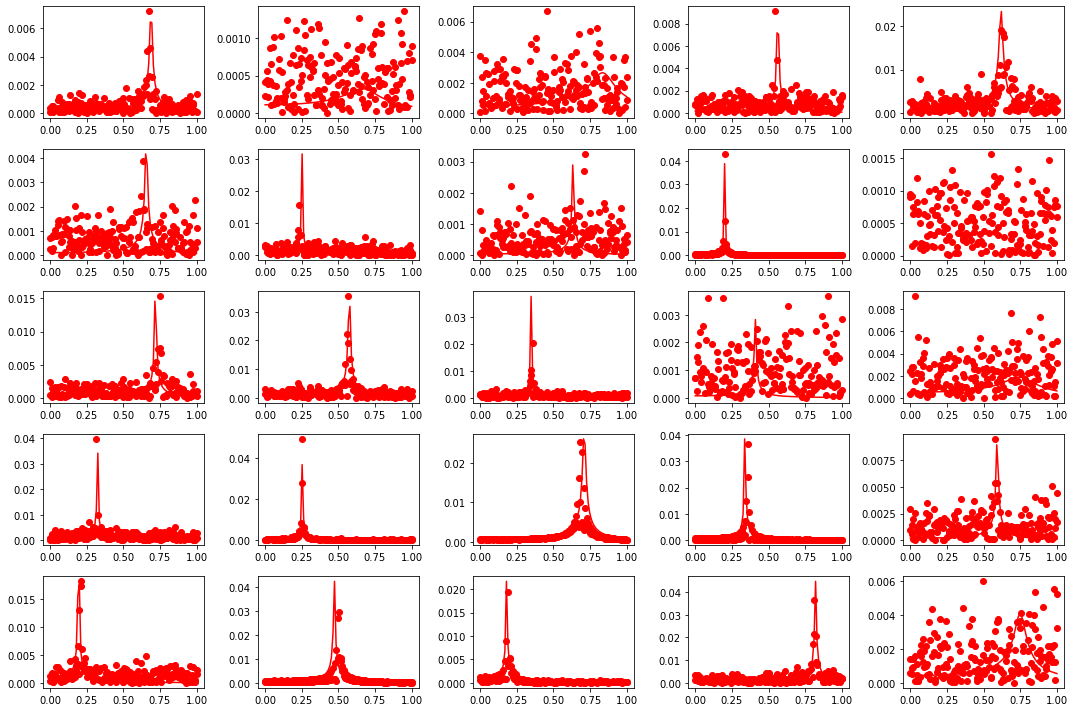

In [5]:
#Try some inference on the data

#Let's  reconstruct the SHO from inferenes
fig, axes = plt.subplots(nrows=5, ncols=5, figsize = (15,10))
for ind, ax in enumerate(axes.flat):
    random_index = np.random.randint(low=0, high = X_test.shape[0])
    xtest = X_test[random_index,:][None,:,:]
    ytest = y_test[random_index,:][None,:]
    
    #print(model.evaluate(xtest, ytest))
    
    yvals = model.predict(xtest)[0]
    
    sho_fit = SHO_fit_func_no_noise(*yvals)
    
    ax.plot(wvec, np.abs(xtest[0]), 'ro')
    ax.plot(wvec, np.abs(sho_fit), 'r-')
    #ax.plot(wvec, np.abs(xtest[0]), 'ro')

fig.tight_layout()


In [6]:
# serialize model to JSON
model_json = model.to_json()
with open("sho_model_arch.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("sho_model_weights.h5")
print("Saved model to disk")


Saved model to disk
